# iLQR Optimal Control Compared with Gradient Descent for a Pendulum with a Sliding Pivot

## Imports

In [ ]:
from typing import Any, Tuple, NamedTuple, Callable
import time
import jax
from jax import Array
import jax.random as jr
import jax.numpy as jnp
from jax import value_and_grad, jit
from optax import adam, apply_updates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from diffilqrax.utils import keygen
from diffilqrax.ilqr import ilqr_solver
from diffilqrax.typs import (
    iLQRParams,
    System,
    ModelDims,
)

jax.config.update('jax_enable_x64', True)

## The Problem

We have a pendulum with masses $m_1=1$ and with lengths $L_1$ and $L_2$ which is released from an arbitrary point and has to be driven to the target position.

The cartesian coordinates of the center of mass of each point are defined as
$$
\begin{align}
x_1 =& L_1 \sin(\theta_1) \\
y_1 =& -L_1 \cos(\theta_1) \\
\end{align}
$$

### Define dynamics

The dynamics of the double pendulum in polar coordinates are given by the following equations:

$$
\ddot{\theta} = \frac{mgl}{J}\sin\theta +\alpha\frac{mgl}{J}\cos\theta - \frac{mgl}{J} u\cos\theta
$$

Setting $\alpha=0.5$, $\frac{mgl}{J}=1$ and initializing system with $\theta=\pi + \epsilon$ and $\dot{\theta}=0$, arrives with simplified dynamics,

$$
% \begin{equation}
\ddot{\theta} = \sin\theta + 0.5\cos\theta - u\cos\theta
% \end{equation}
$$

Outlined in matrix form, where $\mathbf{x}=(x_1,x_2)=(\dot{\theta}, \sin\theta)$, 

$$
\frac{d}{dt}\left( \begin{matrix} \dot{\theta} \\ \sin\theta \end{matrix} \right) = 
\left( \begin{matrix} \alpha\cos\theta & 1 \\ \cos\theta & 0 \end{matrix} \right) \left( \begin{matrix} \dot{\theta} \\ \sin\theta \end{matrix} \right) + 
\left( \begin{matrix} -\cos\theta \\ 0 \end{matrix} \right) u
$$

In the discretised case,
$$
\delta \mathbf{x} =
\left(\begin{matrix}
\delta t \alpha\cos\theta & \delta t \\
\delta t \cos \theta & 0
\end{matrix}\right)
\mathbf{x} + 
\left(\begin{matrix} -\delta t\cos\theta \\ 0\end{matrix}\right) u
$$
and,
$$\mathbf{x}_{k+t} = \mathbf{x}_{k} + \delta \mathbf{x}_k

In [2]:
# define system dimensions
dims = ModelDims(horizon=10000, n=3, m=1, dt=0.001)

In [3]:
class PendulumParams(NamedTuple):
    """Pendulum parameters"""

    m: float
    l: float
    g: float
    dt: float

def pendulum_step(t:int, state:Array, input:Array, theta: PendulumParams)->Array:
    """simulate the dynamics of a pendulum. x0 is sin(theta), x1 is cos(theta), x2 is theta_dot.
    u is the torque applied to the pendulum.

    Args:
        t (int): timepoint
        state (Array): state params
        u (Array): external input
        theta (Theta): parameters
    """
    d_phi, sin_phi, cos_phi = state
    # const = theta.g * theta.l * theta.m
    dyn_mat = jnp.array(
        [
            [.5*cos_phi*theta.dt,       1.*theta.dt,     0.],
            [theta.dt*cos_phi,  0.,              0.],
            [-theta.dt*sin_phi, 0.,              0.],
    ]
        )
    inp_mat = jnp.array(
        [-cos_phi*theta.dt, 
        0.,
        0.]
        )
    d_state = dyn_mat @ state + inp_mat * input
    
    return d_state + state


def rollout(dyn_step: Callable, Us: Array, state_init:Array, prms: Any)-> Array:
    tps = jnp.arange(Us.shape[0])
    
    def fwd_step(state, inputs):
        t, u = inputs
        x = state
        nx = dyn_step(t, x, u, prms)
        return (nx), (nx, u)
    
    xf, (state_traj, input_traj) = jax.lax.scan(fwd_step, init=state_init, xs=(tps, Us))
    
    return jnp.vstack([state_init[None], state_traj]), input_traj

### Define cost function and target state

In [4]:
def cost(t: int, state: Array, inp: Array, theta: Any):
    d_phi, sin_phi, cos_phi = state
    return(
        2.*jnp.sum(d_phi**2) + 
        jnp.sum((sin_phi-jnp.sin(jnp.pi))**2) + 
        jnp.sum((cos_phi-jnp.cos(jnp.pi))**2 + inp**2)
        )
    

def costf(state: Array, theta: Any):
    d_phi, sin_phi, cos_phi = state
    return(
        2.*jnp.sum(d_phi**2) + 
        jnp.sum((sin_phi-jnp.sin(jnp.pi))**2) + 
        jnp.sum((cos_phi-jnp.cos(jnp.pi))**2)
        )

In [5]:
# Define pendulum parameters
pparams = PendulumParams(1.0, 1.0, 9.8, dims.dt)
tt = jnp.linspace(0., (pparams.dt*dims.horizon), dims.horizon+1)
# Initial state
init_ang = jnp.pi/3. + 0.002
init_state = jnp.array([jnp.pi*0., jnp.sin(init_ang), jnp.cos(init_ang)])
params = iLQRParams(x0=init_state, theta=pparams)

# Define initial control sequence
u_init = jnp.zeros((dims.horizon, 1), dtype=jnp.float64)

# Roll out non-linear pendulum dynamics
init_xs, init_us = rollout(pendulum_step, u_init, init_state, pparams)

Text(0.5, 0.98, 'Initial trajectory')

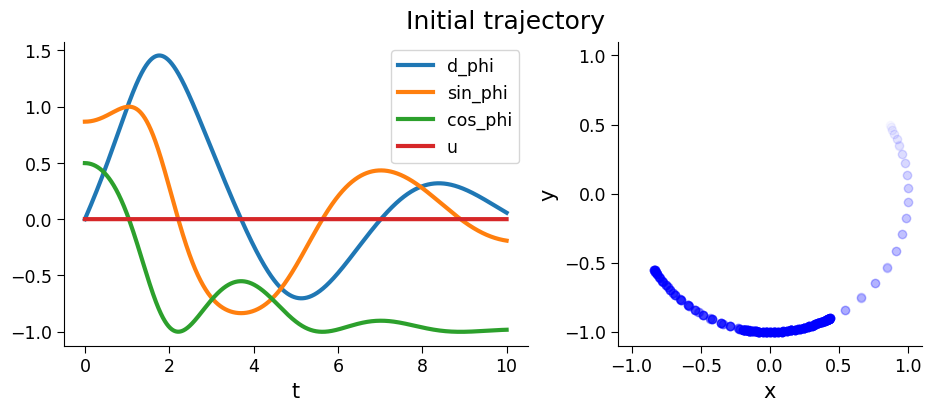

In [6]:
norm = mcolors.Normalize(vmin=tt.min(), vmax=tt.max())
alphas = norm(tt)

fig, ax = plt.subplots(1,2, figsize=(10,4), layout="constrained")
_ = ax[0].plot(tt, init_xs,label=['d_phi', 'sin_phi', 'cos_phi'], lw=3.)
_ = ax[0].plot(tt[:-1], init_us, label='u', lw=3.)
_ = ax[0].set(xlabel='t')
_ = ax[0].legend()

for i in range(0,len(tt),100):
    _ = ax[1].scatter(init_xs[i:i+2,1], init_xs[i:i+2,2], color='blue', alpha=alphas[i])
_ = ax[1].set(xlabel='x', ylabel='y', xlim=[-pparams.l-0.1, pparams.l+0.1], ylim=[-pparams.l-0.1, pparams.l+0.1], aspect="equal")
fig.suptitle("Initial trajectory")

### Set-up pendulum model & iLQR solver

In [7]:
pendulum_problem = System(cost, costf, pendulum_step, dims)

In [8]:
key = jr.PRNGKey(seed=234)
key, skeys = keygen(key, 5)

ls_kwargs = {
    "beta": 0.8,
    "max_iter_linesearch": 16,
    "tol": 1e0,
    "alpha_min": 0.0001,
}


## Solve iLQR problem

In [9]:
# test ilqr solver
ilqr_st = time.time()
(opt_xs, opt_us, opt_lambdas), ilqr_fcost, cost_log = ilqr_solver(
    pendulum_problem,
    params,
    u_init,
    max_iter=70,
    convergence_thresh=1e-10,
    alpha_init=1.0,
    verbose=True,
    use_linesearch=True,
    **ls_kwargs,
)
ilqr_time = time.time()-ilqr_st

Converged in 2/70 iterations
old_cost: 9275.123799007575


Text(0.5, 0.98, 'iLQR optimal trajectory')

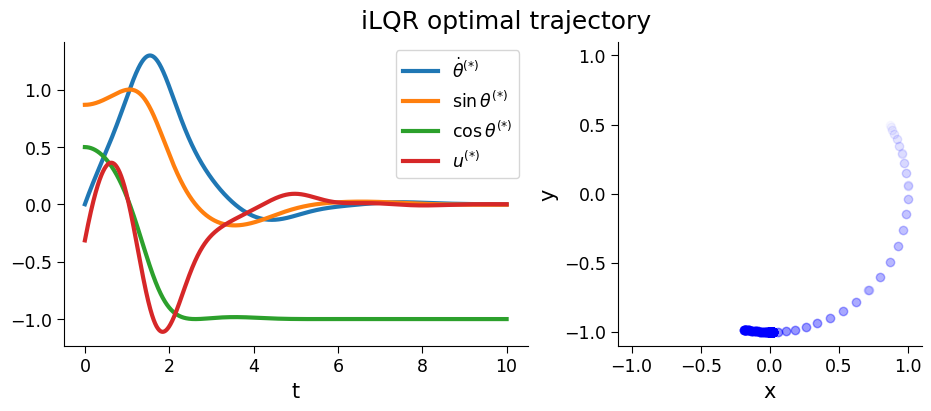

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,4), layout="constrained")
_ = ax[0].plot(tt, opt_xs,label=[r'$\dot{\theta}^{(*)}$', r'$\sin\theta^{(*)}$', r'$\cos\theta^{(*)}$'], lw=3.)
_ = ax[0].plot(tt[:-1], opt_us, label=r'$u^{(*)}$', lw=3.)
_ = ax[0].set(xlabel='t')
_ = ax[0].legend()

for i in range(0,len(tt),100):
    _ = ax[1].scatter(opt_xs[i:i+2,1], opt_xs[i:i+2,2], color='blue', alpha=alphas[i])
_ = ax[1].set(xlabel='x', ylabel='y', xlim=[-pparams.l-0.1, pparams.l+0.1], ylim=[-pparams.l-0.1, pparams.l+0.1], aspect="equal")
fig.suptitle("iLQR optimal trajectory")

## Solve iLQR problem via back-propagation

### Define loss function

In [11]:
# Define loss function
def calc_total_cost(
    dyn: Callable, cst: Callable, fcst: Callable, Us: Array, params: iLQRParams
) -> Tuple[Tuple[Array, Array], float]:
    """Simulate forward cost."""
    x0, theta = params.x0, params.theta
    tps = jnp.arange(10000)

    def fwd_step(state, inputs):
        t, u = inputs
        x, nx_cost = state
        nx = dyn(t, x, u, theta)
        nx_cost = nx_cost + cst(t, x, u, theta)
        return (nx, nx_cost), (nx)

    xf, nx_cost = jax.lax.scan(fwd_step, init=(x0, 0.0), xs=(tps, Us))[0]
    total_cost = nx_cost + fcst(xf, theta)
    return total_cost

# Define gradient function
loss_and_grad_fn = jit(value_and_grad(calc_total_cost, argnums=(3,)), static_argnames=("dyn", "cst", "fcst"))

In [12]:
# Define optimiser parameters and initialisation
lr=1e-3
solver = adam(learning_rate=lr)
opt_state = solver.init((u_init,))

u_updated = u_init

In [13]:
# iterations
losses = jnp.empty(4001//50)
bp_st = time.time()
for rep in range(4001):
    loss, grad = loss_and_grad_fn(pendulum_problem.dynamics, pendulum_problem.cost, pendulum_problem.costf, u_updated, params)
    updates, opt_state = solver.update(grad, opt_state, params)
    u_updated = apply_updates((u_updated,), updates)[0]

    if rep % 50 == 0:
        losses = losses.at[(rep//50)-1].set(loss)
    if rep % 200 == 0:
            print(f"Step {rep}, Loss: {loss:.4f}")
bp_time = time.time()-bp_st

Step 0, Loss: 14192.0423
Step 200, Loss: 11424.5495
Step 400, Loss: 10405.5937
Step 600, Loss: 9891.2053
Step 800, Loss: 9587.5657
Step 1000, Loss: 9407.9038
Step 1200, Loss: 9304.2021
Step 1400, Loss: 9245.7155
Step 1600, Loss: 9213.3939
Step 1800, Loss: 9195.8639
Step 2000, Loss: 9186.5288
Step 2200, Loss: 9181.6516
Step 2400, Loss: 9179.1574
Step 2600, Loss: 9177.9138
Step 2800, Loss: 9177.3125
Step 3000, Loss: 9177.0325
Step 3200, Loss: 9176.9080
Step 3400, Loss: 9176.8555
Step 3600, Loss: 9176.8347
Step 3800, Loss: 9176.8271
Step 4000, Loss: 9176.8245


In [14]:
# view the results
bp_state_traj, bp_input_traj = rollout(pendulum_step, u_updated, params.x0, pparams)

In [15]:
# losses
# rep//50


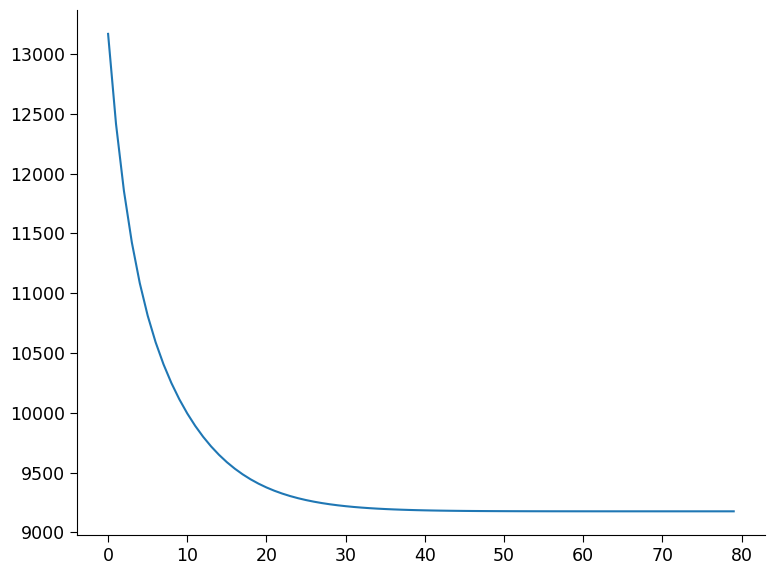

In [16]:
fig,ax = plt.subplots()
ax.plot(losses)

Text(0.5, 0.98, 'Gradient descent optimal trajectory')

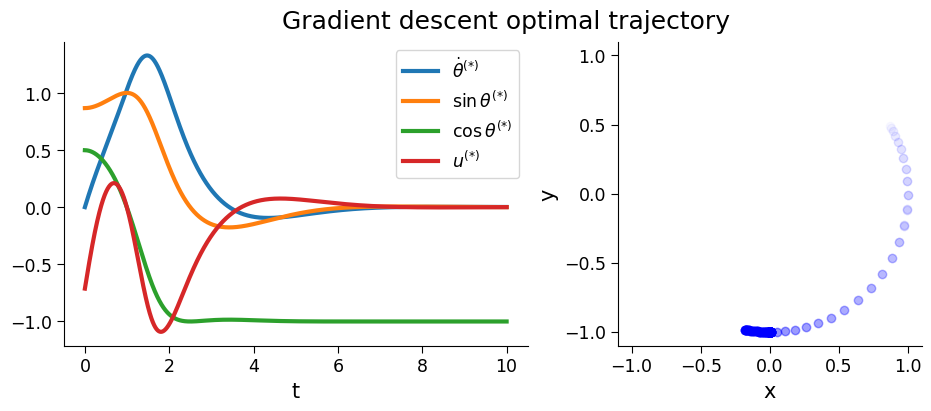

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10,4), layout="constrained")
_ = ax[0].plot(tt, bp_state_traj,label=[r'$\dot{\theta}^{(*)}$', r'$\sin\theta^{(*)}$', r'$\cos\theta^{(*)}$'], lw=3.)
_ = ax[0].plot(tt[:-1], bp_input_traj, label=r'$u^{(*)}$', lw=3.)
_ = ax[0].set(xlabel='t')
_ = ax[0].legend()

for i in range(0,len(tt),100):
    _ = ax[1].scatter(bp_state_traj[i:i+2,1], bp_state_traj[i:i+2,2], color='blue', alpha=alphas[i])
_ = ax[1].set(xlabel='x', ylabel='y', xlim=[-pparams.l-0.1, pparams.l+0.1], ylim=[-pparams.l-0.1, pparams.l+0.1], aspect="equal")
fig.suptitle("Gradient descent optimal trajectory")

## Visualisation

### Time profile

In [18]:
print(f"Clock time","==========",sep="\n")
print(f"iLQR solver:\t\t{ilqr_time:.3f}")
print(f"Back-propagation:\t{bp_time:.3f}")
print("",f"Final Loss","==========",sep="\n")
print(f"iLQR solver:\t\t{ilqr_fcost:.3f}")
print(f"Back-propagation:\t{loss:.3f}")

Clock time
iLQR solver:		10.424
Back-propagation:	172.553

Final Loss
iLQR solver:		9275.124
Back-propagation:	9176.825


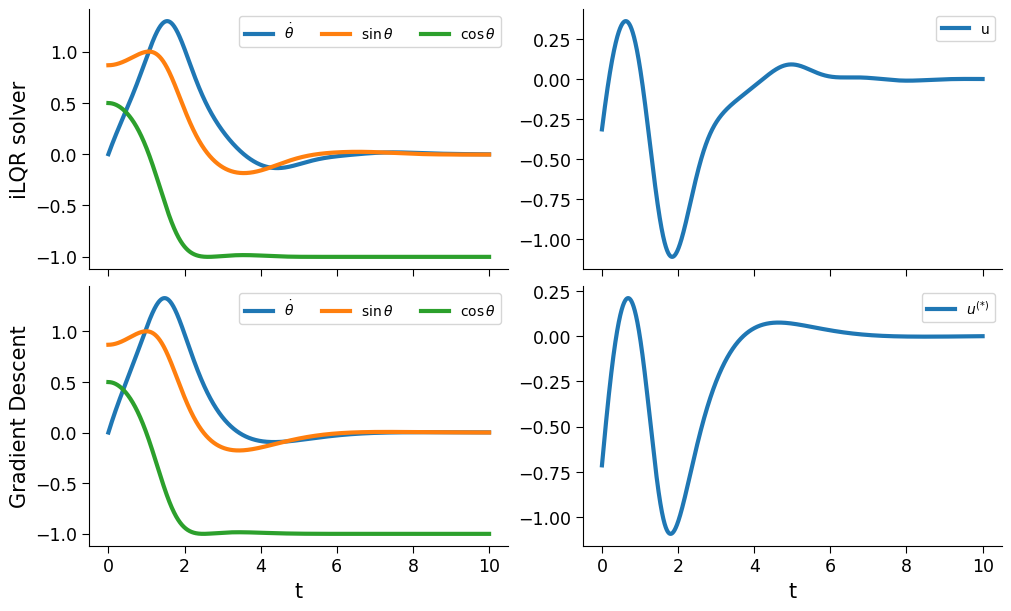

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,6), layout="constrained", sharex="all")
_ = ax[0,0].plot(tt, opt_xs,label=[r'$\dot{\theta}$', r'$\sin\theta$', r'$\cos\theta$'], lw=3)
_ = ax[0,0].set(ylabel="iLQR solver")
_ = ax[0,0].legend(ncol=4, loc='upper right', prop={'size': 10})
_ = ax[0,1].plot(tt[:-1], opt_us, label='u', lw=3)
_ = ax[0,1].legend(ncol=4, loc='upper right', prop={'size': 10})

_ = ax[1,0].plot(tt, bp_state_traj,label=[r'$\dot{\theta}$', r'$\sin\theta$', r'$\cos\theta$'], lw=3)
_ = ax[1,0].set(xlabel='t', ylabel="Gradient Descent")
_ = ax[1,0].legend(ncol=4, loc='upper right', prop={'size': 10})
_ = ax[1,1].plot(tt[:-1], bp_input_traj, label=r'$u^{(*)}$', lw=3)
_ = ax[1,1].set(xlabel='t')
_ = ax[1,1].legend(ncol=4, loc='upper right', prop={'size': 10})